In [1]:
import openmc_sinbad_benchmarks as osb
import helpers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read sinbad data
experiment_file = osb.ResultsFromDatabase('experiment.h5')
mcnp_eff3_file = osb.ResultsFromDatabase('mcnp_eff3.h5')
mcnp_fendl1_file = osb.ResultsFromDatabase('mcnp_fendl1.h5')
mcnp_fendl2_file = osb.ResultsFromDatabase('mcnp_fendl2.h5')

In [3]:
# read openmc results
openmc_onaxis1 = osb.ResultsFromOpenmc('statepoint_old.100.h5', 'reaction_rates_onaxis')
openmc_onaxis2 = osb.ResultsFromOpenmc('statepoint_old.100.h5', 'reaction_rates_onaxis')
openmc_offaxis = osb.ResultsFromOpenmc('statepoint_old.100.h5', 'reaction_rates_offaxis')
openmc_heating = osb.ResultsFromOpenmc('statepoint_old.100.h5', 'heating')

In [4]:
# initialize reaction rate plots
foil_list = ['nb93', 'al27', 'ni58', 'au197']
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', '$^{58}$Ni(n,p)$^{58}$Co', '$^{197}$Au(n,\u03B3)$^{198}$Au']
ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

[b'0.25' b'12.95' b'25.95' b'38.65' b'43.82' b'46.35' b'53.3' b'60.05'
 b'66.9' b'73.9' b'80.6' b'87.25' b'91.65']
[b'0.25' b'12.95' b'25.95' b'38.65' b'43.82' b'46.35' b'53.3' b'60.05'
 b'66.9' b'73.9' b'80.6' b'87.25' b'91.65']
[b'0.25' b'12.95' b'25.95' b'38.65' b'43.82' b'46.35' b'53.3' b'60.05'
 b'66.9' b'73.9' b'80.6' b'87.25' b'91.65']
[b'0.25' b'12.95' b'25.95' b'38.65' b'43.92' b'46.35' b'53.3' b'60.05'
 b'66.6' b'73.9' b'80.6' b'87.25' b'91.65']


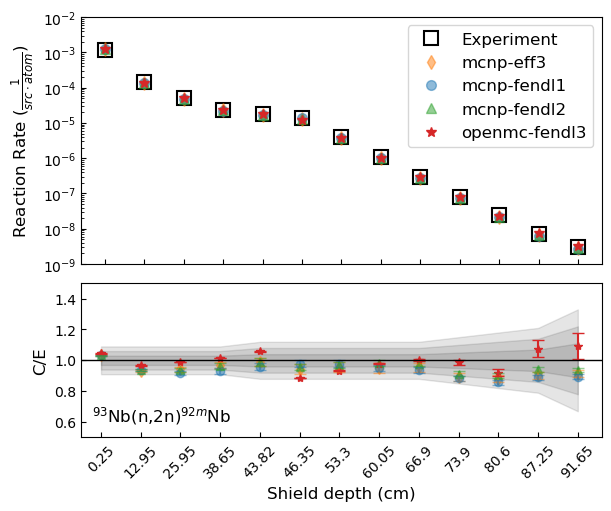

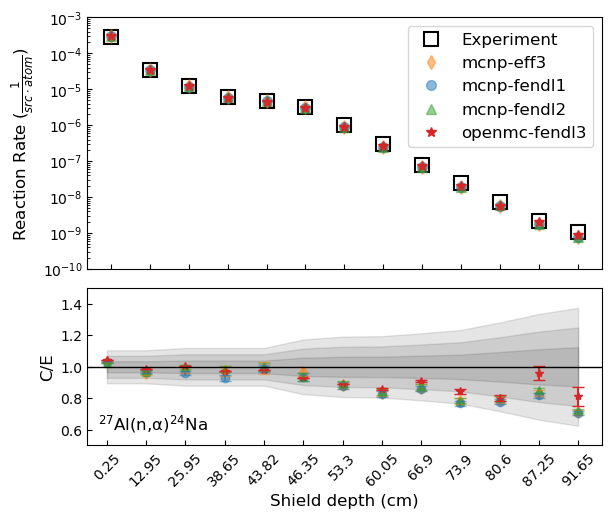

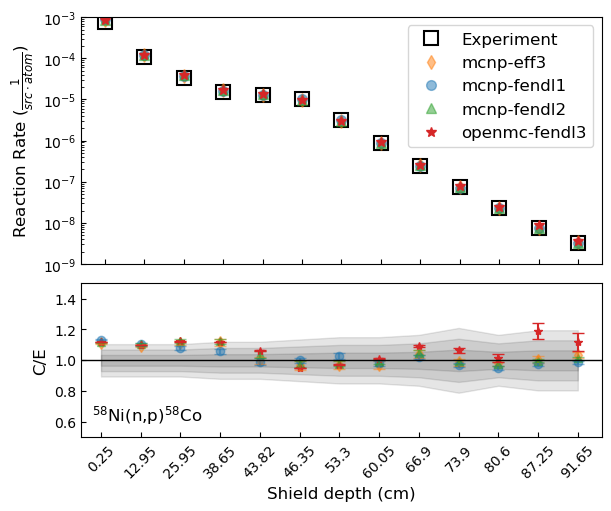

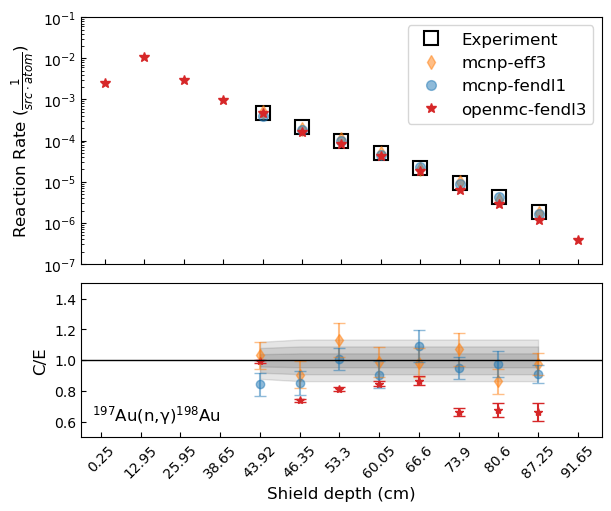

In [5]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    # mcnpp-fendl2 does not have Au197 reaction rates
    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_onaxis1_{foil}')
    except:
        mcnp_fendl2 = None
    # read openmc results from its statepoint file
    openmc_fendl3 = openmc_onaxis1.get_tally_dataframe(f'rr_onaxis1_{foil}', normalize_over=helpers.volumes_onaxis1)
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_onaxis1_{foil}')
    means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], np.array(openmc_fendl3['mean'])]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
    ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
    if mcnp_fendl2 is not None:
        ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')
    
    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')

    osb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
    if mcnp_fendl2 is not None:
        ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')

    # adjust
    osb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.5, 1.5])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

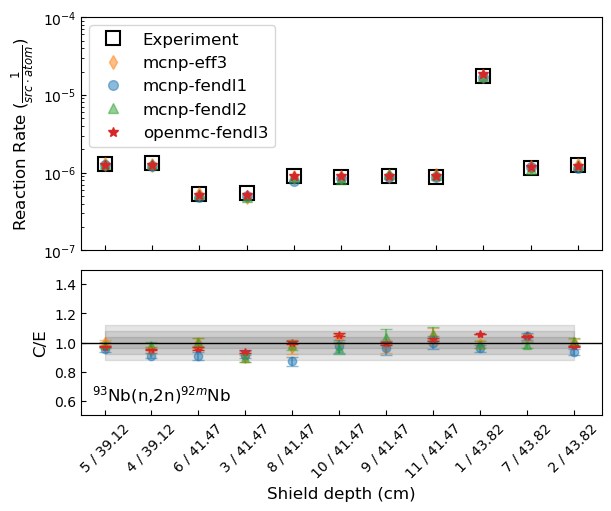

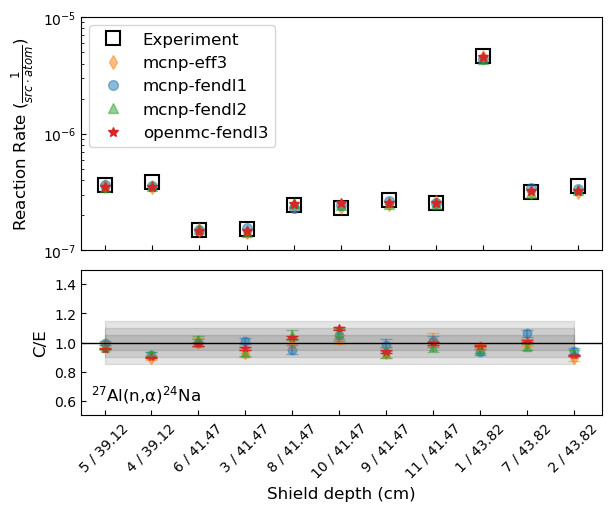

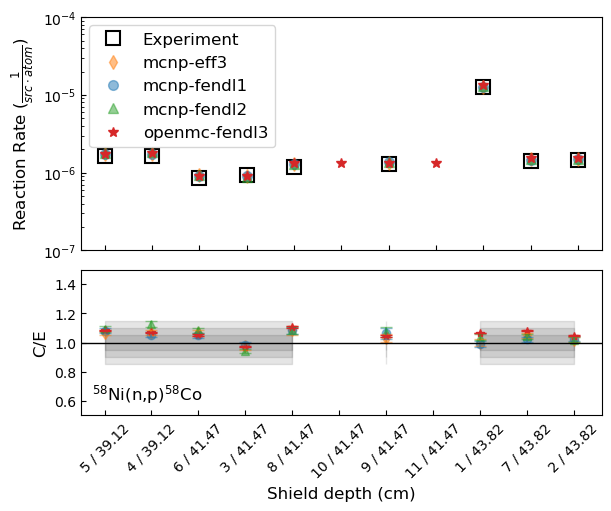

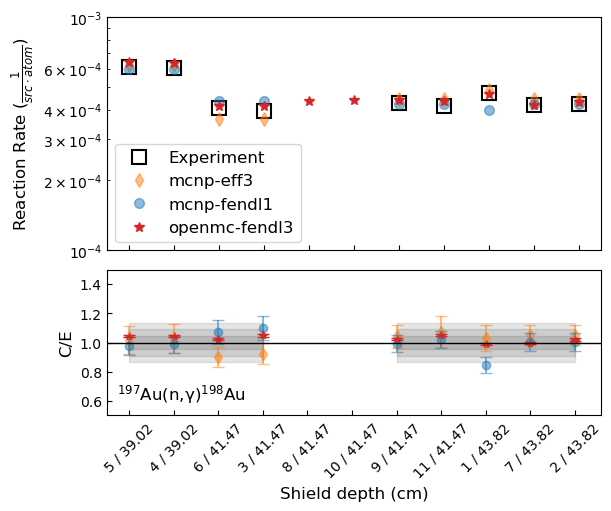

In [6]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    # mcnpp-fendl2 does not have Au197 reaction rates
    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_onaxis2_{foil}')
    except:
        mcnp_fendl2 = None
    # read openmc results from its statepoint file
    openmc_fendl3 = openmc_onaxis2.get_tally_dataframe(f'rr_onaxis2_{foil}', normalize_over=helpers.volumes_onaxis2)
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_onaxis2_{foil}')
    means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], np.array(openmc_fendl3['mean'])]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
    ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
    if mcnp_fendl2 is not None:
        ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')
    
    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')

    osb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
    if mcnp_fendl2 is not None:
        ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')

    # adjust
    osb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.5, 1.5])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

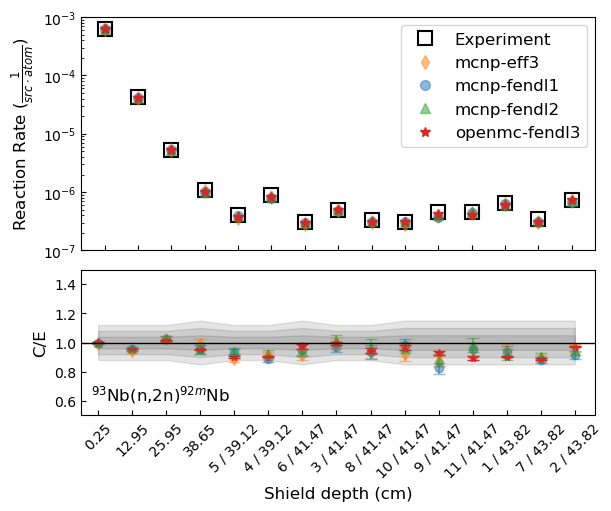

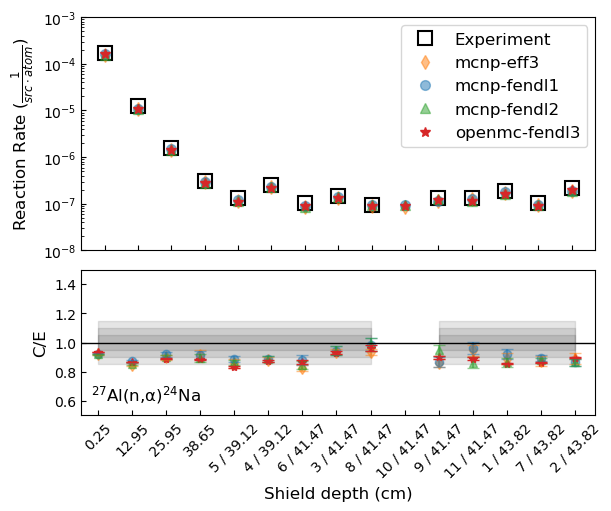

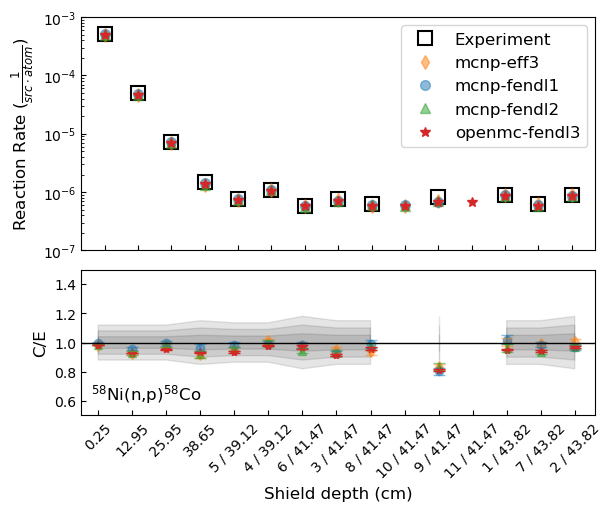

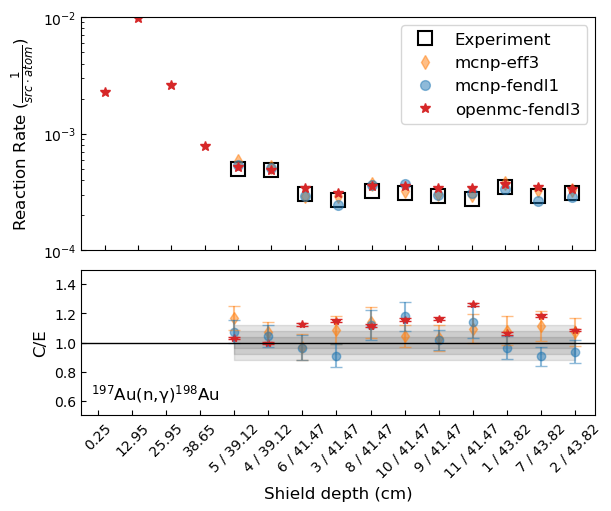

In [7]:
for i,foil in enumerate(foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    # mcnpp-fendl2 does not have Au197 reaction rates
    try:
        mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe(f'rr_offaxis_{foil}')
    except:
        mcnp_fendl2 = None
    # read openmc results from its statepoint file
    openmc_fendl3 = openmc_offaxis.get_tally_dataframe(f'rr_offaxis_{foil}', normalize_over=helpers.volumes_offaxis)
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_offaxis_{foil}')
    means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], np.array(openmc_fendl3['mean'])]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
    ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
    ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
    if mcnp_fendl2 is not None:
        ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')
    
    # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')

    osb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
                marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
    ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
                marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
    if mcnp_fendl2 is not None:
        ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
                marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')

    # adjust
    osb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.5, 1.5])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

In [8]:
openmc_df = openmc_heating.get_tally_dataframe('nuclear_heating')
qtld = mcnp_fendl2_file.get_tally_dataframe('qtld_coefficients')
openmc_fendl3 = helpers.postprocess_openmc_heating(openmc_df, qtld)

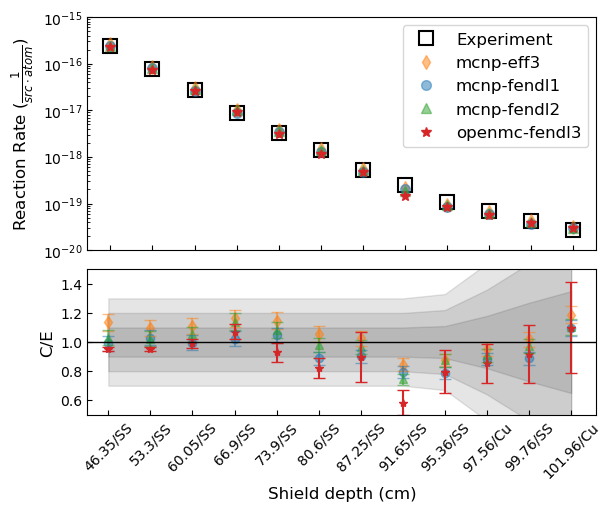

In [9]:
# extract tallies
measured = experiment_file.get_tally_dataframe('nuclear_heating')
mcnp_eff3 = mcnp_eff3_file.get_tally_dataframe('nuclear_heating')
mcnp_fendl1 = mcnp_fendl1_file.get_tally_dataframe('nuclear_heating')
mcnp_fendl2 = mcnp_fendl2_file.get_tally_dataframe('nuclear_heating')

# plot
# preprocessing
dtype_label = reaction_labels[i]
tickers = np.arange(len(measured))
xaxis = experiment_file.get_tally_xaxis('nuclear_heating')
means = [measured['mean'], mcnp_eff3['mean'], mcnp_fendl1['mean'], mcnp_fendl2['mean']]

# generate figure
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

# plot results
ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')
ax1.plot(tickers, mcnp_eff3['mean'], marker='d', ms=7, ls='none', color='tab:orange', alpha=0.5, label='mcnp-eff3')
ax1.plot(tickers, mcnp_fendl1['mean'], marker='o', ms=7, ls='none', color='tab:blue', alpha=0.5, label='mcnp-fendl1')
ax1.plot(tickers, mcnp_fendl2['mean'], marker='^', ms=7, ls='none', color='tab:green', alpha=0.5, label='mcnp-fendl2')

# openmc results
ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', label='openmc-fendl3')

osb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
ax2.errorbar(tickers, mcnp_eff3['mean']/measured['mean'], mcnp_eff3['std. dev.']/measured['mean'], 
            marker='d', ms=6, capsize=4, barsabove=True, color='tab:orange', ls='none', alpha=0.5, label='_label')
ax2.errorbar(tickers, mcnp_fendl1['mean']/measured['mean'], mcnp_fendl1['std. dev.']/measured['mean'], 
            marker='o', ms=6, capsize=4, barsabove=True, color='tab:blue', ls='none', alpha=0.5, label='_label')
if mcnp_fendl2 is not None:
    ax2.errorbar(tickers, mcnp_fendl2['mean']/measured['mean'], mcnp_fendl2['std. dev.']/measured['mean'], 
            marker='^', ms=6, capsize=4, barsabove=True, color='tab:green', ls='none', alpha=0.5, label='_label')
    
# openmc results
ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
            marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', label='_label')

# adjust
osb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
ax1.set_yscale('log')
ax1.set_ylabel(ylabel, fontsize=12)
ax1.set_xticks(tickers)
ax1.tick_params(axis='x', labelbottom=False)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.legend(fontsize=12)
#
ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
            linewidth=1, label='_nolegend_')
ax2.set_xlim([-0.5, tickers[-1] + .6])
ax2.set_ylim([0.5, 1.5])
ax2.set_xticks(tickers)
ax2.set_xticklabels([el.decode() for el in measured[xaxis]])
ax2.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='both', which='both', direction='in')
ax2.set_xlabel(xaxis, fontsize=12)
ax2.set_ylabel('C/E', fontsize=12)

plt.show()